In [17]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
from scipy.stats import mannwhitneyu, wilcoxon, combine_pvalues

# Append base directory
import os,sys,inspect
rootname = "pub-2020-exploratory-analysis"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from mesostat.metric.metric import MetricCalculator
from mesostat.metric.idtxl_pid import bivariate_pid_3D
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.hdf5_io import DataStorage
from mesostat.utils.signals import bin_data
from mesostat.utils.pandas_helper import pd_append_row, pd_query
from mesostat.stat.permtests import percentile_twosided, perm_test_resample


from lib.sych.data_fc_db_raw import DataFCDatabase
from lib.sych.plot_helper import imshow_dataset_by_mouse, imshow_dataset_by_session
from lib.sych.metric_helper import metric_by_session, metric_by_selector

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/pub-2020-exploratory-analysis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
# params['root_path_data'] = './'
params['root_path_data'] = '/media/alyosha/Data/TE_data/yarodata/sych_preprocessed'
#params['root_path_data'] = gui_fpath('h5path', './')

In [4]:
dataDB = DataFCDatabase(params)

Searching for data files


In [5]:
h5outname = 'sych_result_higher_order_df.h5'

In [6]:
mc = MetricCalculator(serial=False, verbose=False, nCore=4)

Redirecting STDOUT to log_6384.txt
Redirecting STDOUT to log_6385.txt
Redirecting STDOUT to log_6387.txt
Redirecting STDOUT to log_6386.txt
Resumed STDOUT
Redirecting STDOUT to log_6385.txt
Resumed STDOUT
Resumed STDOUT
Resumed STDOUT
Resumed STDOUT
Redirecting STDOUT to log_6384.txt
Redirecting STDOUT to log_6387.txt
Redirecting STDOUT to log_6386.txt
Redirecting STDOUT to log_6385.txt
Resumed STDOUT
Redirecting STDOUT to log_6387.txt
Resumed STDOUT
Resumed STDOUT
Resumed STDOUT
Resumed STDOUT
Redirecting STDOUT to log_6384.txt
Redirecting STDOUT to log_6386.txt
Redirecting STDOUT to log_6385.txt
Redirecting STDOUT to log_6387.txt
Resumed STDOUT
Resumed STDOUT
Resumed STDOUT
Redirecting STDOUT to log_6386.txt
Resumed STDOUT
Resumed STDOUT
Redirecting STDOUT to log_6385.txt
Redirecting STDOUT to log_6384.txt
Redirecting STDOUT to log_6386.txt
Redirecting STDOUT to log_6387.txt
Resumed STDOUT
Resumed STDOUT
Redirecting STDOUT to log_6384.txt
Resumed STDOUT
Resumed STDOUT
Resumed STDOUT


# Hypotheses

* H1) Feedforwards Prefrontal
    - Sources={M1, S1};   Targets={ PrL, LO, VO, M2 или Cg1}
* H2) High order is Sensory/Motor Thalamus
    - Sources={M1, S1};   Targets={PO, VM} 
* H3) Thalamus as source
    - Sources={VPM, PO};  Targets={S1, S2}
* H4) Motor Thalamus synchronization
    - Sources={VM, VL, LD};    Targets={M1,M2}
    
    
New Hypotheses:
* H1a) Sources={S1, S2}  Targets={ PrL, LO, VO, M2 или Cg1}
* H1b) Sources={M1, M2}  Targets={ PrL, LO, VO, M2 или Cg1}   (drop M2)
* H2a) Sources={S1, S2}  Targets={PO, VM} 
* H2b) Sources={M1, M2}  Targets={PO, VM} 
    - Maybe Having M1, S1 gets more Info than M1, M2 or S1, S2
    
Hypothesis - Chain inhibition should increase synergy
* Cpu -> iGP/GP/eGP -> VM/VL


Performance-depencence
* Session-wise changes of redundancy/synergy as function of performance
* Movement-correlations of synergy/redundancy
    - Lick
    - Integral movement

In [72]:
def calc_pid(dataDB, sources, targets, mousename, datatype, zscoreDim, cropTime, trialType, performance, nPerm=1000):
    channelNames = dataDB.get_channel_labels(mousename)
    sourceIdxs = [channelNames.index(s) for s in sources]
    targetIdxs = [channelNames.index(t) for t in targets]
    
    dataLst = dataDB.get_neuro_data({'mousename' : mousename}, datatype=datatype,
                                    zscoreDim=zscoreDim, cropTime=cropTime,
                                    trialType=trialType, performance=performance)
    
    data = np.concatenate(dataLst, axis=0)
    data = np.mean(data, axis=1)  # Average out time
    data = bin_data(data, 4, axis=1)
    
    settings_estimator = {'pid_estimator': 'TartuPID', 'lags_pid': [0, 0]}
    
    mc.set_data(data, 'rp')
    rez = mc.metric3D('BivariatePID', '',
                      metricSettings={'settings_estimator' : settings_estimator,
                                      'src' : sourceIdxs},
                      sweepSettings={'trg' : targetIdxs})
    
    # Since all channels are binned to the same quantiles,
    # the permutation test is exactly the same for all of them, so we need any three channels as input
    settings_test = {'src' : [0, 1], 'trg' : 2, 'settings_estimator' : settings_estimator}
    fTest = lambda x: bivariate_pid_3D(x, settings_test)
    dataTest = data[:, :3][..., None]  # Add fake 1D sample dimension
    
    fRand = perm_test_resample(fTest, dataTest, nPerm, iterAxis=1)
    
    rezTest = [
        percentile_twosided(fTrue, fRand, settings={"haveEffectSize" : True, "haveMeans" : True})
        for fTrue in rez
    ]
    
    rezTest = np.array(rezTest)
    df = pd.DataFrame(columns=['mousename', 'S1', 'S2', 'T', 'PID', 'p', 'effSize', 'muTrue', 'muRand'])
    for iTrg, trgName in enumerate(targets):
        for iType, infType in enumerate(['U1', 'U2', 'red', 'syn']):
            rowLst = [mousename, *sources, trgName, infType, *rezTest[iTrg, 1:, iType]]
            df = pd_append_row(df, rowLst, skip_repeat=False)
                
    return df

def plot_pid_pval_aggr(h5fname, groupkey):
    df = pd.read_hdf(h5fname, key=groupkey)
    pidTypes = ['U1', 'U2', 'red', 'syn']
    
    fig, ax = plt.subplots()
    for s1 in sorted(set(df['S1'])):
        for s2 in sorted(set(df['S2'])):
            if s1 != s2:
                for t in sorted(set(df['T'])):
                    label = '('+s1+','+s2+')->'+t
                    pLst = []

                    for pidType in pidTypes:
                        rows = pd_query(df, {'S1':s1, 'S2':s2, 'T':t, 'PID':pidType})
                        assert len(rows) == len(dataDB.mice)
                        p = combine_pvalues(list(rows['p']))[1]

                        pLst += [-np.log10(p)]

                    ax.plot(pLst, label=label)
                
    ax.legend()
    ax.set_ylabel('-log10(p)')
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['Unique1', 'Unique2', 'Redundancy', 'Synergy'])
    plt.axhline(y=2, linestyle='--', color='r')
    plt.show()
        
        
def plot_pid_metric_bymouse(h5fname, groupkey, metricKey, metricName, yscale=None, clip=None, ylim=None):
    df = pd.read_hdf(h5fname, key=groupkey)
    pidTypes = ['U1', 'U2', 'red', 'syn']
    
    nMice = len(dataDB.mice)
    fig, ax = plt.subplots(ncols=nMice, figsize=(6*nMice, 6))
    
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        for s1 in sorted(set(df['S1'])):
            for s2 in sorted(set(df['S2'])):
                if s1 != s2:
                    for t in sorted(set(df['T'])):
                        label = '('+s1+','+s2+')->'+t
                        metricLst = []

                        for pidType in pidTypes:
                            rows = pd_query(df, {'mousename':mousename,'S1':s1, 'S2':s2, 'T':t, 'PID':pidType})
                            assert len(rows) == 1
                            
                            metricLst += [list(rows[metricKey])[0]]
                            
                        if clip is not None:
                            metricLst = np.clip(metricLst, *clip)

                        ax[iMouse].plot(metricLst, label=label)
                        
        ax[iMouse].legend()
        ax[iMouse].set_title(mousename)
        ax[iMouse].set_ylabel(metricName)
        ax[iMouse].set_xticks([0,1,2,3])
        ax[iMouse].set_xticklabels(['Unique1', 'Unique2', 'Redundancy', 'Synergy'])
        if yscale is not None:
            ax[iMouse].set_yscale(yscale)
        if ylim is not None:
            ax[iMouse].set_ylim(ylim)
    
    plt.show()

# H1

In [9]:
sources = ['M1_l', 'S1_bf']
targets = ['PrL', 'LO', 'VO', 'M2', 'Cg1']

rezDF1 = pd.DataFrame()
for mousename in dataDB.mice:
    dfTmp = calc_pid(dataDB, sources, targets, mousename, 'bn_session', None, [3, 3.5], 'iGO', 'expert', nPerm=2000)
    rezDF1 = rezDF1.append(dfTmp)

Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


In [10]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(rezDF1.sort_values(by=['S1', 'S2', 'T', 'PID', 'mousename']))

,mousename,S1,S2,T,PID,p,effSize,muTrue,muRand
16,mvg_4,M1_l,S1_bf,Cg1,U1,0.0005,47.268136,2.372204e-01,0.007430
16,mvg_7,M1_l,S1_bf,Cg1,U1,0.0005,192.232940,9.792637e-01,0.007608
16,mvg_8,M1_l,S1_bf,Cg1,U1,0.0005,48.527154,1.632286e-01,0.005009
16,mvg_9,M1_l,S1_bf,Cg1,U1,0.0055,3.651312,3.357836e-02,0.009585
17,mvg_4,M1_l,S1_bf,Cg1,U2,0.4050,0.006191,7.195345e-03,0.007166
17,mvg_7,M1_l,S1_bf,Cg1,U2,0.9995,-1.501748,-2.423373e-10,0.007266
17,mvg_8,M1_l,S1_bf,Cg1,U2,0.0010,4.274089,1.845889e-02,0.004880
17,mvg_9,M1_l,S1_bf,Cg1,U2,0.9800,-1.366107,1.127180e-03,0.009692
18,mvg_4,M1_l,S1_bf,Cg1,red,0.0005,452.281383,9.719008e-01,0.004277
18,mvg_7,M1_l,S1_bf,Cg1,red,0.0005,39.341743,8.897641e-02,0.004225


In [11]:
rezDF1.to_hdf(h5outname, 'PID_H1_TEX', mode='a', format='table', data_columns=True)

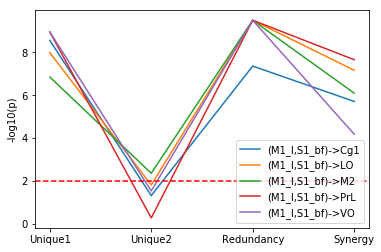

In [46]:
plot_pid_pval_aggr(h5outname, 'PID_H1_TEX')

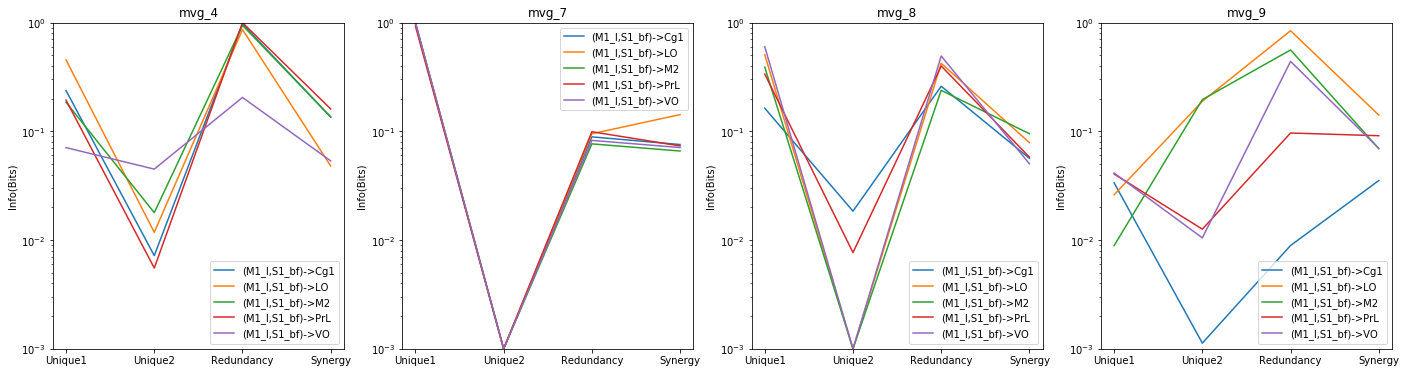

In [73]:
plot_pid_metric_bymouse(h5outname, 'PID_H1_TEX', 'muTrue', 'Info(Bits)', yscale='log', clip=[1.0E-3, 1], ylim=[1.0E-3, 1])

# H2

In [27]:
sources = ['M1_l', 'S1_bf']
targets = ['Po', 'VM']

rezDF2 = pd.DataFrame()
for mousename in dataDB.mice:
    dfTmp = calc_pid(dataDB, sources, targets, mousename, 'bn_session', None, [3, 3.5], 'iGO', 'expert', nPerm=2000)
    rezDF2 = rezDF2.append(dfTmp)

Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(rezDF2.sort_values(by=['S1', 'S2', 'T', 'PID', 'mousename']))

,mousename,S1,S2,T,PID,p,effSize,muTrue,muRand
0,mvg_4,M1_l,S1_bf,Po,U1,0.0005,10.813862,5.948215e-02,0.007446
0,mvg_7,M1_l,S1_bf,Po,U1,0.0005,109.853207,5.327958e-01,0.007336
0,mvg_8,M1_l,S1_bf,Po,U1,0.0005,150.115989,5.158136e-01,0.005048
0,mvg_9,M1_l,S1_bf,Po,U1,0.5655,-0.340330,7.663302e-03,0.009839
1,mvg_4,M1_l,S1_bf,Po,U2,0.0020,3.968262,2.587120e-02,0.007142
1,mvg_7,M1_l,S1_bf,Po,U2,0.0640,1.773504,1.613876e-02,0.007493
1,mvg_8,M1_l,S1_bf,Po,U2,0.9995,-1.575122,-8.492813e-11,0.004927
1,mvg_9,M1_l,S1_bf,Po,U2,0.0005,14.209574,1.017612e-01,0.009927
2,mvg_4,M1_l,S1_bf,Po,red,0.0005,163.906303,3.742887e-01,0.004211
2,mvg_7,M1_l,S1_bf,Po,red,0.0005,20.457187,5.037708e-02,0.004214


In [29]:
rezDF2.to_hdf(h5outname, 'PID_H2_TEX', mode='a', format='table', data_columns=True)

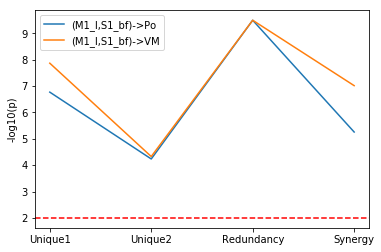

In [30]:
plot_pid_pval_aggr(h5outname, 'PID_H2_TEX')

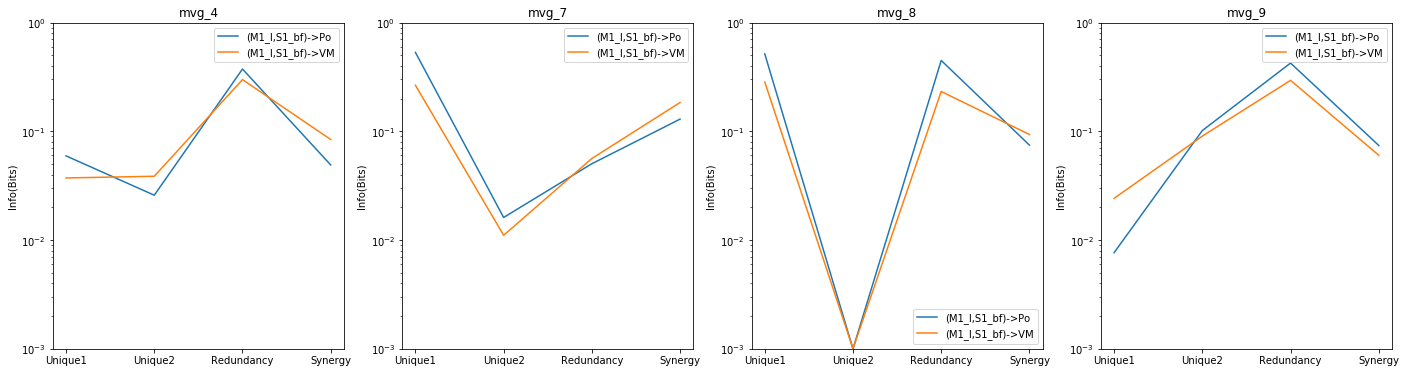

In [74]:
plot_pid_metric_bymouse(h5outname, 'PID_H2_TEX', 'muTrue', 'Info(Bits)', yscale='log', clip=[1.0E-3, 1], ylim=[1.0E-3, 1])

# H3

In [31]:
sources = ['Po', 'VPM']
targets = ['S1_bf', 'S2']

rezDF3 = pd.DataFrame()
for mousename in dataDB.mice:
    dfTmp = calc_pid(dataDB, sources, targets, mousename, 'bn_session', None, [3, 3.5], 'iGO', 'expert')
    rezDF3 = rezDF3.append(dfTmp)

Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt


In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(rezDF3.sort_values(by=['S1', 'S2', 'T', 'PID', 'mousename']))

,mousename,S1,S2,T,PID,p,effSize,muTrue,muRand
0,mvg_4,Po,VPM,S1_bf,U1,0.001,65.289246,0.333366,0.007319
0,mvg_7,Po,VPM,S1_bf,U1,0.001,5.943555,0.037646,0.007537
0,mvg_8,Po,VPM,S1_bf,U1,0.001,14.603015,0.053362,0.004945
0,mvg_9,Po,VPM,S1_bf,U1,0.001,59.537382,0.383055,0.009534
1,mvg_4,Po,VPM,S1_bf,U2,0.001,19.688676,0.104632,0.007571
1,mvg_7,Po,VPM,S1_bf,U2,0.006,3.738482,0.026107,0.007492
1,mvg_8,Po,VPM,S1_bf,U2,0.001,14.998251,0.053321,0.004872
1,mvg_9,Po,VPM,S1_bf,U2,0.164,0.882573,0.016286,0.010201
2,mvg_4,Po,VPM,S1_bf,red,0.001,28.146136,0.066794,0.004299
2,mvg_7,Po,VPM,S1_bf,red,0.001,11.792702,0.028869,0.004224


In [33]:
rezDF3.to_hdf(h5outname, 'PID_H3_TEX', mode='a', format='table', data_columns=True)

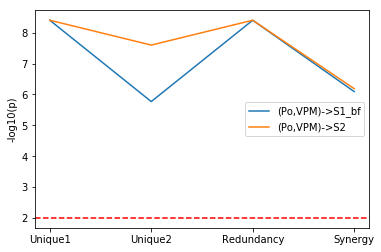

In [39]:
plot_pid_pval_aggr(h5outname, 'PID_H3_TEX')

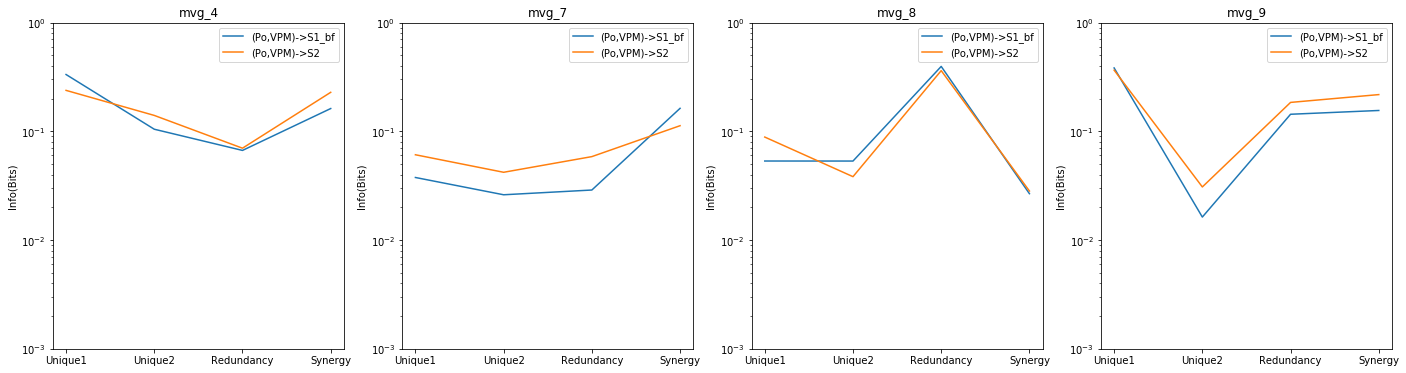

In [75]:
plot_pid_metric_bymouse(h5outname, 'PID_H3_TEX', 'muTrue', 'Info(Bits)', yscale='log', clip=[1.0E-3, 1], ylim=[1.0E-3, 1])

# H4

In [35]:
sources1 = ['VM', 'VL']
sources2 = ['VM', 'LDVL']
sources3 = ['VL', 'LDVL']
targets = ['M1_l', 'M2']

rezDF4 = pd.DataFrame()
for mousename in dataDB.mice:
    dfTmp1 = calc_pid(dataDB, sources1, targets, mousename, 'bn_session', None, [3, 3.5], 'iGO', 'expert')
    dfTmp2 = calc_pid(dataDB, sources2, targets, mousename, 'bn_session', None, [3, 3.5], 'iGO', 'expert')
    dfTmp3 = calc_pid(dataDB, sources3, targets, mousename, 'bn_session', None, [3, 3.5], 'iGO', 'expert')
    
    rezDF4 = rezDF4.append(dfTmp1)
    rezDF4 = rezDF4.append(dfTmp2)
    rezDF4 = rezDF4.append(dfTmp3)

Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT
Redirecting STDOUT to log_5294.txt
Resumed STDOUT


In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(rezDF4.sort_values(by=['S1', 'S2', 'T', 'PID', 'mousename']))

,mousename,S1,S2,T,PID,p,effSize,muTrue,muRand
0,mvg_4,VL,LDVL,M1_l,U1,0.001,81.877137,3.873505e-01,0.007232
0,mvg_7,VL,LDVL,M1_l,U1,0.009,2.961220,2.282458e-02,0.007790
0,mvg_8,VL,LDVL,M1_l,U1,0.001,31.944398,1.071363e-01,0.005089
0,mvg_9,VL,LDVL,M1_l,U1,0.634,-0.505448,6.642331e-03,0.010114
1,mvg_4,VL,LDVL,M1_l,U2,0.001,11.531012,6.528223e-02,0.007370
1,mvg_7,VL,LDVL,M1_l,U2,0.001,8.498314,4.844885e-02,0.007258
1,mvg_8,VL,LDVL,M1_l,U2,0.001,8.820663,3.252242e-02,0.004848
1,mvg_9,VL,LDVL,M1_l,U2,0.001,65.643272,4.266257e-01,0.009921
2,mvg_4,VL,LDVL,M1_l,red,0.001,247.525314,5.117863e-01,0.004032
2,mvg_7,VL,LDVL,M1_l,red,0.001,502.722252,1.070047e+00,0.004192


In [37]:
rezDF4.to_hdf(h5outname, 'PID_H4_TEX', mode='a', format='table', data_columns=True)

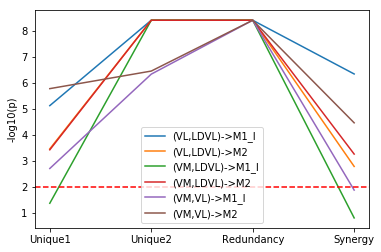

In [41]:
plot_pid_pval_aggr(h5outname, 'PID_H4_TEX')

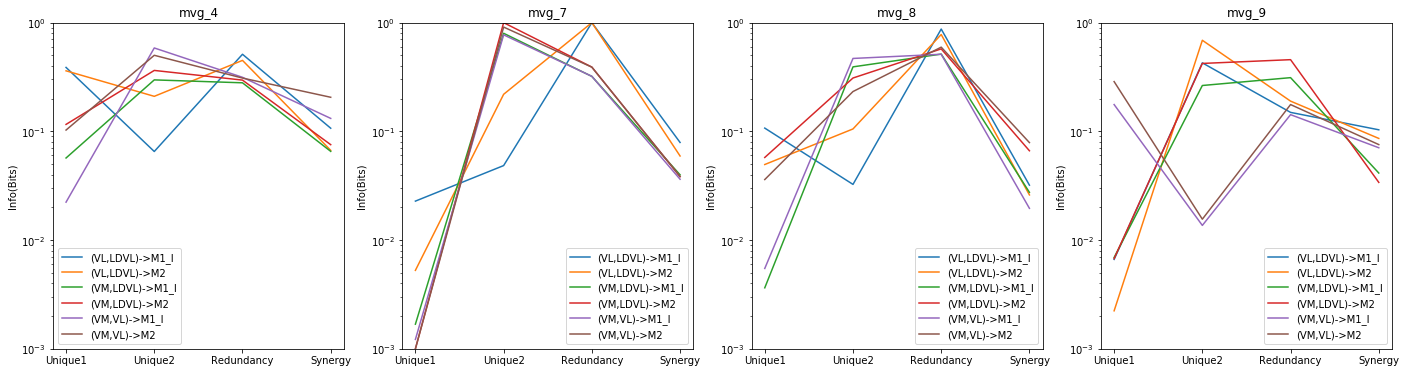

In [76]:
plot_pid_metric_bymouse(h5outname, 'PID_H4_TEX', 'muTrue', 'Info(Bits)', yscale='log', clip=[1.0E-3, 1], ylim=[1.0E-3, 1])

In [79]:
np.array(dataDB.get_channel_labels('mvg_4'))

array(['M1_l', 'AI', 'M1_m', 'Pir', 'LO', 'AOL', 'AOD', 'M2', 'VO', 'Cg1',
       'PrL', 'MO', 'IV2', 'S', 'CA1_Mol', 'DG_p', 'V1_m', 'BIC', 'SubB',
       'RSG', 'InWh', 'DpMe', 'SuG', 'LPAG', 'S1_bf', 'Cpu', 'BLA',
       'S1_bf', 'BMA', 'Rt', 'iGP', 'VPM', 'CA1_Py', 'VM', 'dCA1', 'Sub',
       'S2', 'LaDL', 'Cpu', 'LGP', 'eGP', 'GP', 'VPL', 'LDVL', 'Po', 'VL',
       'M2', 'DG_a'], dtype='<U7')